# Jupyter notebook sample

In [2]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [3]:
# Read the data
df = pd.read_csv('customer_segmentation.csv')

In [5]:
# Get basic information about the dataset
print(df.shape)  # Number of rows and columns
print(df.columns)  # Column names

(10127, 14)
Index(['customer_id', 'age', 'gender', 'dependent_count', 'education_level',
       'marital_status', 'estimated_income', 'months_on_book',
       'total_relationship_count', 'months_inactive_12_mon', 'credit_limit',
       'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio'],
      dtype='object')


In [6]:
# Check the data types
print(df.dtypes)

# Check for categorical variables
categorical_cols = df.select_dtypes(include='object').columns
print(categorical_cols)

customer_id                   int64
age                           int64
gender                       object
dependent_count               int64
education_level              object
marital_status               object
estimated_income              int64
months_on_book                int64
total_relationship_count      int64
months_inactive_12_mon        int64
credit_limit                float64
total_trans_amount            int64
total_trans_count             int64
avg_utilization_ratio       float64
dtype: object
Index(['gender', 'education_level', 'marital_status'], dtype='object')


In [7]:
# Check for missing values
print(df.isnull().sum())

# You may decide to fill or drop missing values based on the business context

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64


In [9]:
# Calculate correlation
correlation_matrix = df.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'M'

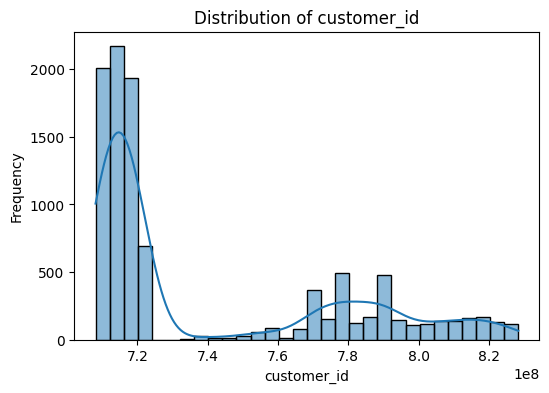

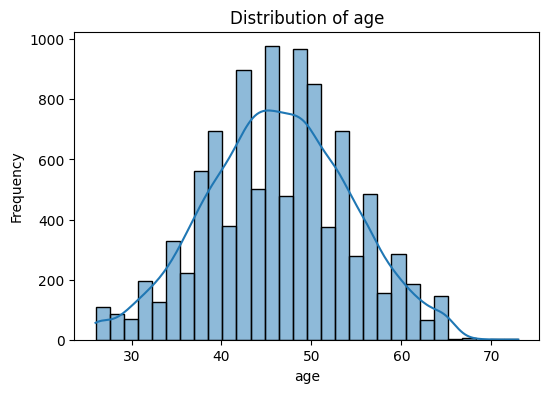

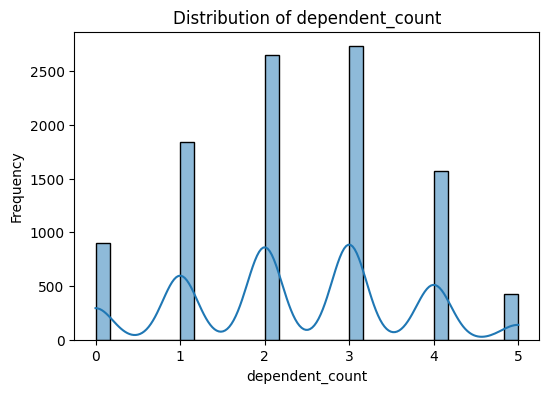

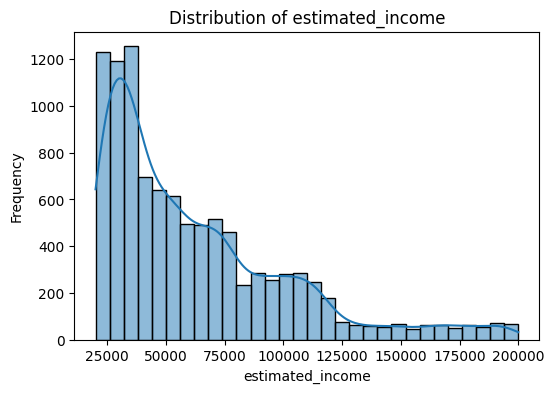

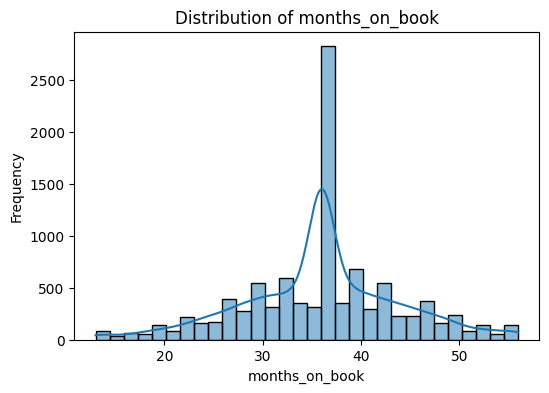

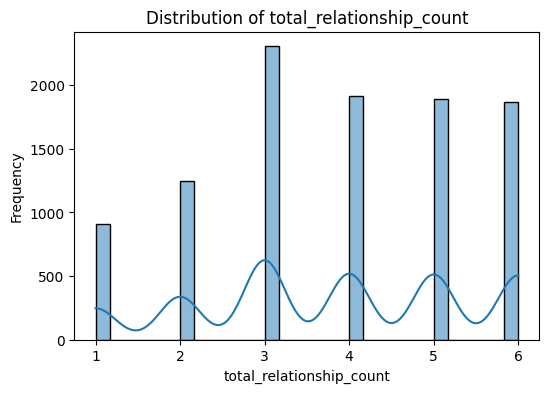

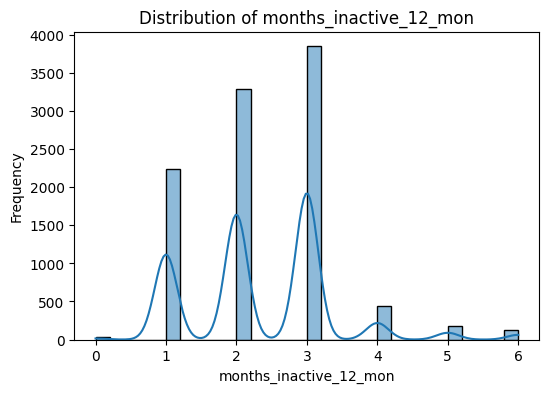

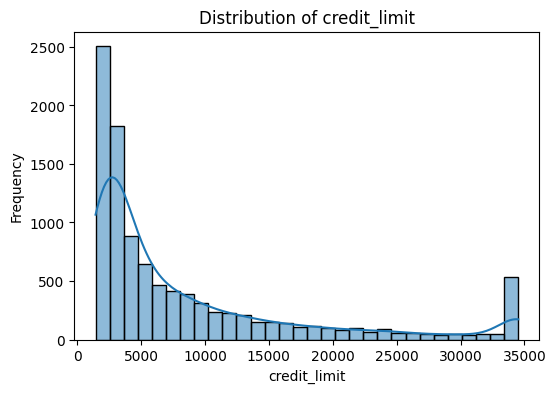

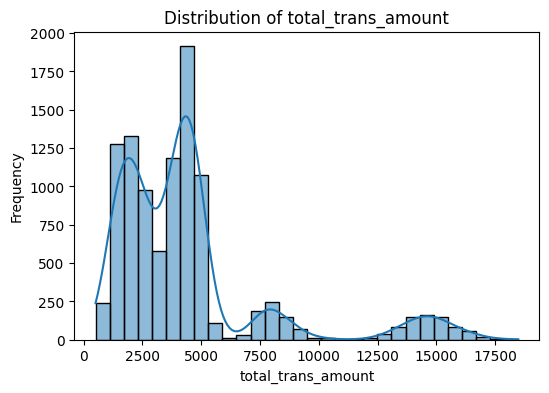

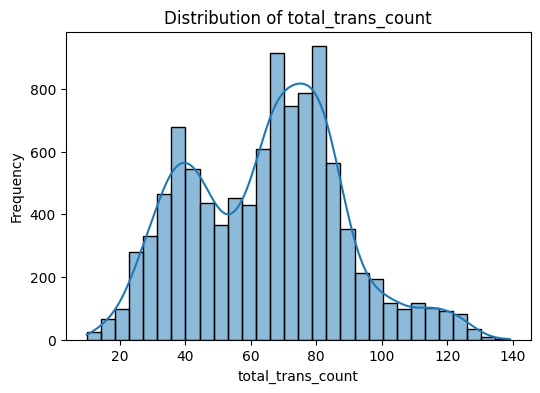

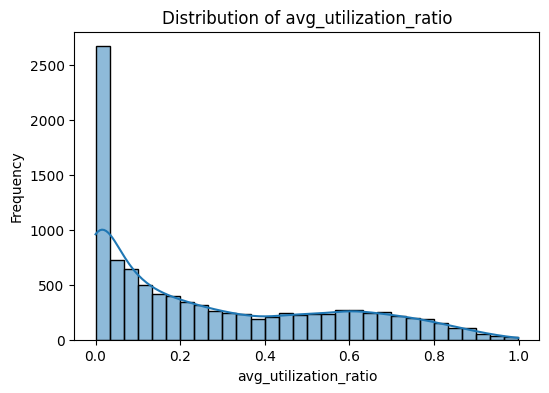

In [10]:
# Plot distributions
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
	plt.figure(figsize=(6, 4))
	sns.histplot(df[col], bins=30, kde=True)
	plt.title(f'Distribution of {col}')
	plt.xlabel(col)
	plt.ylabel('Frequency')
	plt.show()